In [ ]:
!pip install pytesseract easyocr paddlepaddle paddleocr surya-ocr jiwer

  Using cached paddleocr-2.10.0-py3-none-any.whl.metadata (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 83.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 29.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 100.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 15.9 MB/s eta

In [ ]:
!pip install git+https://github.com/VikParuchuri/surya.git

  Cloning https://github.com/VikParuchuri/surya.git to /tmp/pip-req-build-yy70pejl
  Running command git clone --filter=blob:none --quiet https://github.com/VikParuchuri/surya.git /tmp/pip-req-build-yy70pejl
  Resolved https://github.com/VikParuchuri/surya.git to commit 7e5ac9d5afce743f503d453f09bcdb2552ebaaad
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for surya-ocr: filename=surya_ocr-0.13.0-py3-none-any.whl size=154139 sha256=b22124a6a0d6e3547b43d1a818c086efc55a7a84e4ce3f7561f793306ad44534
  Stored in directory: /tmp/pip-ephem-wheel-cache-aysbi15u/wheels/8c/a3/57/c8cae03eae6eb76ea145f67e3256edea1d9302f92178a8e7a6
Successfully built surya-ocr
  Attempting uninstall: surya-ocr
    Found existing installation: surya-ocr 0.12.1
    Uninstalling surya-ocr-0.12.1:
      Successfully uninstalled surya-ocr-0.12.1
ERROR: pip's dependency resolver does not currently take into account all

In [ ]:
!pip install --upgrade opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 28.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84


In [ ]:
!mkdir -p ./tessdata
!wget -q -O ./tessdata/rus.traineddata https://github.com/tesseract-ocr/tessdata/raw/main/rus.traineddata

In [ ]:
import os
os.environ["TESSDATA_PREFIX"] = os.path.abspath(".") + "/tessdata/"
print(os.environ["TESSDATA_PREFIX"])

/kaggle/working/tessdata/


In [ ]:
import easyocr
import pytesseract
from paddleocr import PaddleOCR
from surya.recognition import RecognitionPredictor
from surya.detection import DetectionPredictor
from PIL import Image
from pathlib import Path
import pandas as pd
import numpy as np
import jiwer
import cv2

# Load dataset
dataset_path = Path("/kaggle/input/donkeysmallocr-cyrillic-printed-8")  # I used 50 images from https://huggingface.co/datasets/DonkeySmall/OCR-Cyrillic-Printed-8
test_csv = dataset_path / "test/test.txt"

df_test = pd.read_csv(test_csv, sep=",", names=["filename", "text"])
df_test["filepath"] = df_test["filename"].apply(lambda x: str(dataset_path / "test" / x))

# Take 2 images for fast testing
df_sample = df_test.sample(50)

In [ ]:
def ocr_tesseract(image_path):
    return pytesseract.image_to_string(Image.open(image_path), lang='rus').strip()

easyocr_reader = easyocr.Reader(['ru'], gpu=True)

def ocr_easyocr(image_path):
    result = easyocr_reader.readtext(image_path)  # detail=True по умолчанию
    text_parts = [item[1] for item in result]     # item = (bbox, text, conf)
    return ' '.join(text_parts).strip()

paddleocr_reader = PaddleOCR(use_angle_cls=True, lang='ru', gpu=True)

def ocr_paddleocr(image_path):
    result = paddleocr_reader.ocr(image_path, cls=True)

    if result and result[0]:  # убедимся, что результат не пустой и есть строки
        text = ' '.join([line[1][0] for line in result[0]])
        return text.strip()
    return ""  # если ничего не распозналось

def ocr_surya(image_path):
    langs = ["ru"]
    recognition_predictor = RecognitionPredictor()
    image=Image.open(image_path).convert("RGB")
    width, height = image.size
    full_poly = [[0, 0], [width, 0], [width, height], [0, height]]
    polygons = [[full_poly]]
    predictions=recognition_predictor([image], [langs], None, polygons=polygons)
    text_blocks = [text_line.text for text_line in predictions[0].text_lines]
    result=" ".join(text_blocks)
    return result

[2025/03/21 13:20:24] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/cyrillic/cyrillic_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_b

In [ ]:
# Process Batch Requests & Compute WER using JiWER
cer_scores = []
models = {"TesseractOCR": ocr_tesseract, "EasyOCR": ocr_easyocr, "PaddleOCR": ocr_paddleocr, "SuryaOCR": ocr_surya}

for _, row in df_sample.iterrows():
    img_path = row["filepath"]
    true_text = row["text"]

    for model_name, ocr_function in models.items():
        pred_text = ocr_function(img_path)  # Perform OCR

        # Compute CER using JiWER
        cer_score = jiwer.cer(true_text.strip().lower().replace(" ", ""), pred_text.strip().lower().replace(" ", ""))

        cer_scores.append({
            "Model": model_name,
            "Image": img_path,
            "CER": cer_score,
            "Reference": true_text,
            "Prediction": pred_text
        })

# Convert results to DataFrame
df_cer = pd.DataFrame(cer_scores)

[2025/03/21 13:26:33] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.017241716384887695
[2025/03/21 13:26:33] ppocr DEBUG: cls num  : 1, elapsed : 0.011070013046264648
[2025/03/21 13:26:33] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09247279167175293
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


[2025/03/21 13:26:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.01119232177734375
[2025/03/21 13:26:34] ppocr DEBUG: cls num  : 1, elapsed : 0.010657548904418945
[2025/03/21 13:26:34] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1212167739868164
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


[2025/03/21 13:26:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009237527847290039
[2025/03/21 13:26:36] ppocr DEBUG: cls num  : 1, elapsed : 0.011475563049316406
[2025/03/21 13:26:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08439111709594727
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


[2025/03/21 13:26:38] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010312557220458984
[2025/03/21 13:26:38] ppocr DEBUG: cls num  : 1, elapsed : 0.010803461074829102
[2025/03/21 13:26:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0923454761505127
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


[2025/03/21 13:26:39] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009991645812988281
[2025/03/21 13:26:39] ppocr DEBUG: cls num  : 1, elapsed : 0.010695934295654297
[2025/03/21 13:26:39] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08137989044189453
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


[2025/03/21 13:26:41] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0105133056640625
[2025/03/21 13:26:41] ppocr DEBUG: cls num  : 1, elapsed : 0.010359764099121094
[2025/03/21 13:26:41] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08112668991088867
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


[2025/03/21 13:26:42] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009255409240722656
[2025/03/21 13:26:42] ppocr DEBUG: cls num  : 1, elapsed : 0.011300802230834961
[2025/03/21 13:26:42] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08417701721191406
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


[2025/03/21 13:26:44] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009484291076660156
[2025/03/21 13:26:44] ppocr DEBUG: cls num  : 1, elapsed : 0.00998544692993164
[2025/03/21 13:26:44] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08603024482727051
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


[2025/03/21 13:26:46] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010712623596191406
[2025/03/21 13:26:46] ppocr DEBUG: cls num  : 1, elapsed : 0.011122703552246094
[2025/03/21 13:26:46] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08115530014038086
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


[2025/03/21 13:26:47] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011984586715698242
[2025/03/21 13:26:48] ppocr DEBUG: cls num  : 1, elapsed : 0.010960102081298828
[2025/03/21 13:26:48] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12137699127197266
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


[2025/03/21 13:26:49] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.012113571166992188
[2025/03/21 13:26:49] ppocr DEBUG: cls num  : 1, elapsed : 0.0102386474609375
[2025/03/21 13:26:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12073206901550293
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


[2025/03/21 13:26:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009919166564941406
[2025/03/21 13:26:51] ppocr DEBUG: cls num  : 1, elapsed : 0.01108241081237793
[2025/03/21 13:26:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08660340309143066
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


[2025/03/21 13:26:53] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009754180908203125
[2025/03/21 13:26:53] ppocr DEBUG: cls num  : 1, elapsed : 0.011015176773071289
[2025/03/21 13:26:53] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08349728584289551
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


[2025/03/21 13:26:54] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009908437728881836
[2025/03/21 13:26:54] ppocr DEBUG: cls num  : 1, elapsed : 0.010358095169067383
[2025/03/21 13:26:54] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08028268814086914
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


[2025/03/21 13:26:56] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010068893432617188
[2025/03/21 13:26:56] ppocr DEBUG: cls num  : 1, elapsed : 0.010483980178833008
[2025/03/21 13:26:56] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10001444816589355
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


[2025/03/21 13:26:57] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.010915994644165039
[2025/03/21 13:26:57] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/03/21 13:26:58] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


[2025/03/21 13:26:59] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010850667953491211
[2025/03/21 13:26:59] ppocr DEBUG: cls num  : 1, elapsed : 0.010182380676269531
[2025/03/21 13:26:59] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10325789451599121
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


[2025/03/21 13:27:01] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009197711944580078
[2025/03/21 13:27:01] ppocr DEBUG: cls num  : 1, elapsed : 0.010536670684814453
[2025/03/21 13:27:01] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07812809944152832
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


[2025/03/21 13:27:02] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.008697748184204102
[2025/03/21 13:27:02] ppocr DEBUG: cls num  : 1, elapsed : 0.010723590850830078
[2025/03/21 13:27:02] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08185029029846191
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


[2025/03/21 13:27:04] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010651588439941406
[2025/03/21 13:27:04] ppocr DEBUG: cls num  : 1, elapsed : 0.010964155197143555
[2025/03/21 13:27:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09611845016479492
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


[2025/03/21 13:27:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.013672351837158203
[2025/03/21 13:27:05] ppocr DEBUG: cls num  : 1, elapsed : 0.011121749877929688
[2025/03/21 13:27:06] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08568239212036133
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


[2025/03/21 13:27:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010036945343017578
[2025/03/21 13:27:07] ppocr DEBUG: cls num  : 1, elapsed : 0.01028132438659668
[2025/03/21 13:27:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08233428001403809
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


[2025/03/21 13:27:09] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.008971691131591797
[2025/03/21 13:27:09] ppocr DEBUG: cls num  : 1, elapsed : 0.011513948440551758
[2025/03/21 13:27:09] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08021926879882812
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


[2025/03/21 13:27:11] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009825468063354492
[2025/03/21 13:27:11] ppocr DEBUG: cls num  : 1, elapsed : 0.011631488800048828
[2025/03/21 13:27:11] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08461928367614746
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


[2025/03/21 13:27:12] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010551214218139648
[2025/03/21 13:27:12] ppocr DEBUG: cls num  : 1, elapsed : 0.009935855865478516
[2025/03/21 13:27:12] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1051182746887207
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


[2025/03/21 13:27:14] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010373830795288086
[2025/03/21 13:27:14] ppocr DEBUG: cls num  : 1, elapsed : 0.010492563247680664
[2025/03/21 13:27:14] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08927321434020996
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


[2025/03/21 13:27:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011439085006713867
[2025/03/21 13:27:16] ppocr DEBUG: cls num  : 1, elapsed : 0.010850667953491211
[2025/03/21 13:27:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10411381721496582
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


[2025/03/21 13:27:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010704755783081055
[2025/03/21 13:27:17] ppocr DEBUG: cls num  : 1, elapsed : 0.010435819625854492
[2025/03/21 13:27:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08351421356201172
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


[2025/03/21 13:27:19] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.012190103530883789
[2025/03/21 13:27:19] ppocr DEBUG: cls num  : 1, elapsed : 0.011537790298461914
[2025/03/21 13:27:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11532044410705566
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


[2025/03/21 13:27:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.007959127426147461
[2025/03/21 13:27:21] ppocr DEBUG: cls num  : 1, elapsed : 0.01054835319519043
[2025/03/21 13:27:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08166790008544922
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


[2025/03/21 13:27:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010832786560058594
[2025/03/21 13:27:22] ppocr DEBUG: cls num  : 1, elapsed : 0.011226177215576172
[2025/03/21 13:27:23] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1280040740966797
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


[2025/03/21 13:27:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.008858919143676758
[2025/03/21 13:27:24] ppocr DEBUG: cls num  : 1, elapsed : 0.010233640670776367
[2025/03/21 13:27:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07843780517578125
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


[2025/03/21 13:27:26] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009209156036376953
[2025/03/21 13:27:26] ppocr DEBUG: cls num  : 1, elapsed : 0.009879112243652344
[2025/03/21 13:27:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07906985282897949
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


[2025/03/21 13:27:27] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011408805847167969
[2025/03/21 13:27:27] ppocr DEBUG: cls num  : 1, elapsed : 0.011436700820922852
[2025/03/21 13:27:27] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12522196769714355
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


[2025/03/21 13:27:29] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.01038670539855957
[2025/03/21 13:27:29] ppocr DEBUG: cls num  : 1, elapsed : 0.010408163070678711
[2025/03/21 13:27:29] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08486032485961914
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


[2025/03/21 13:27:31] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011470794677734375
[2025/03/21 13:27:31] ppocr DEBUG: cls num  : 1, elapsed : 0.01183176040649414
[2025/03/21 13:27:31] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10195589065551758
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


[2025/03/21 13:27:33] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.01156473159790039
[2025/03/21 13:27:33] ppocr DEBUG: cls num  : 1, elapsed : 0.010807991027832031
[2025/03/21 13:27:33] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11065173149108887
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


[2025/03/21 13:27:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010139942169189453
[2025/03/21 13:27:34] ppocr DEBUG: cls num  : 1, elapsed : 0.01039576530456543
[2025/03/21 13:27:34] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08866095542907715
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


[2025/03/21 13:27:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009890556335449219
[2025/03/21 13:27:36] ppocr DEBUG: cls num  : 1, elapsed : 0.0107269287109375
[2025/03/21 13:27:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0828866958618164
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


[2025/03/21 13:27:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009034156799316406
[2025/03/21 13:27:38] ppocr DEBUG: cls num  : 1, elapsed : 0.010816097259521484
[2025/03/21 13:27:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08638286590576172
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


[2025/03/21 13:27:39] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011016368865966797
[2025/03/21 13:27:39] ppocr DEBUG: cls num  : 1, elapsed : 0.011587142944335938
[2025/03/21 13:27:39] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1116940975189209
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


[2025/03/21 13:27:41] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009400606155395508
[2025/03/21 13:27:41] ppocr DEBUG: cls num  : 1, elapsed : 0.01015925407409668
[2025/03/21 13:27:41] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07947778701782227
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


[2025/03/21 13:27:42] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010922431945800781
[2025/03/21 13:27:42] ppocr DEBUG: cls num  : 1, elapsed : 0.01095724105834961
[2025/03/21 13:27:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11018013954162598
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


[2025/03/21 13:27:44] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010548114776611328
[2025/03/21 13:27:44] ppocr DEBUG: cls num  : 1, elapsed : 0.010318994522094727
[2025/03/21 13:27:44] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08809328079223633
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


[2025/03/21 13:27:46] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.008922338485717773
[2025/03/21 13:27:46] ppocr DEBUG: cls num  : 1, elapsed : 0.011619329452514648
[2025/03/21 13:27:46] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08318924903869629
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


[2025/03/21 13:27:47] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009732246398925781
[2025/03/21 13:27:47] ppocr DEBUG: cls num  : 1, elapsed : 0.01119542121887207
[2025/03/21 13:27:47] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08561420440673828
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


[2025/03/21 13:27:49] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009439945220947266
[2025/03/21 13:27:49] ppocr DEBUG: cls num  : 1, elapsed : 0.010921955108642578
[2025/03/21 13:27:49] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11371326446533203
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


[2025/03/21 13:27:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009443283081054688
[2025/03/21 13:27:51] ppocr DEBUG: cls num  : 1, elapsed : 0.010617733001708984
[2025/03/21 13:27:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08310747146606445
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


[2025/03/21 13:27:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011033296585083008
[2025/03/21 13:27:52] ppocr DEBUG: cls num  : 1, elapsed : 0.010002613067626953
[2025/03/21 13:27:53] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0913546085357666
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


[2025/03/21 13:27:54] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011141061782836914
[2025/03/21 13:27:54] ppocr DEBUG: cls num  : 1, elapsed : 0.011709213256835938
[2025/03/21 13:27:54] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09798979759216309
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


In [ ]:
df_cer

,Model,Image,CER,Reference,Prediction
0,TesseractOCR,/kaggle/input/donkeysmallocr-cyrillic-printed-...,0.000000,КУКУРУЗНОЕ,КУКУРУЗНОЕ
1,EasyOCR,/kaggle/input/donkeysmallocr-cyrillic-printed-...,0.000000,КУКУРУЗНОЕ,КУКУРУЗНОЕ
2,PaddleOCR,/kaggle/input/donkeysmallocr-cyrillic-printed-...,0.700000,КУКУРУЗНОЕ,KVKуPуЗHOL
3,SuryaOCR,/kaggle/input/donkeysmallocr-cyrillic-printed-...,0.000000,КУКУРУЗНОЕ,КУКУРУЗНОЕ
4,TesseractOCR,/kaggle/input/donkeysmallocr-cyrillic-printed-...,0.090909,составлялся,сославлялся
...,...,...,...,...,...
195,SuryaOCR,/kaggle/input/donkeysmallocr-cyrillic-printed-...,0.000000,НАРАБОТАНЫ,НАРАБОТАНЫ
196,TesseractOCR,/kaggle/input/donkeysmallocr-cyrillic-printed-...,0.111111,эсминцами,эсминцамм
197,EasyOCR,/kaggle/input/donkeysmallocr-cyrillic-printed-...,0.000000,эсминцами,эсминцами
198,PaddleOCR,/kaggle/input/donkeysmallocr-cyrillic-printed-...,0.000000,эсминцами,эсминцами


In [ ]:
# Save to CSV
df_cer.to_csv("/kaggle/working/cer_results_ocr.csv", mode="w", index=False)

# Print confirmation
print("CER results saved: /kaggle/working/cer_results_ocr.csv")

CER results saved: /kaggle/working/cer_results_ocr.csv


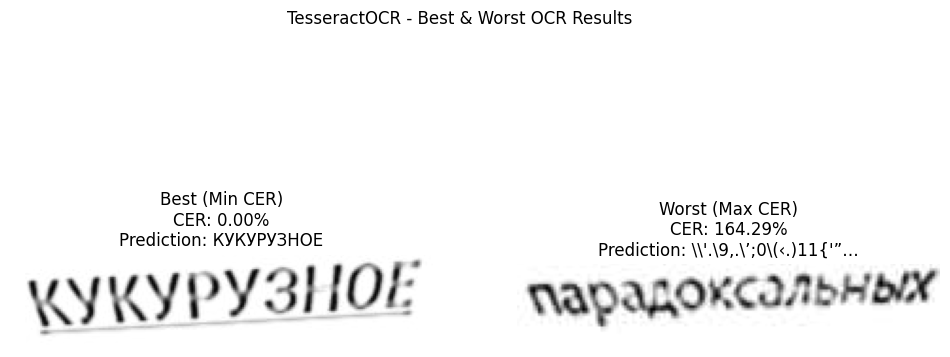

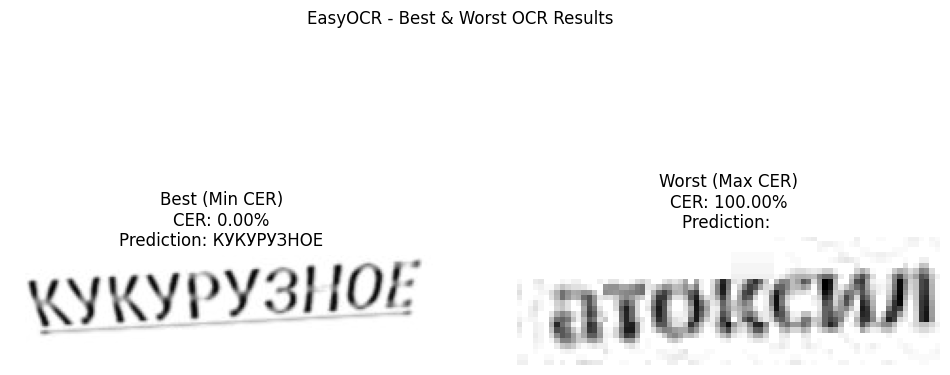

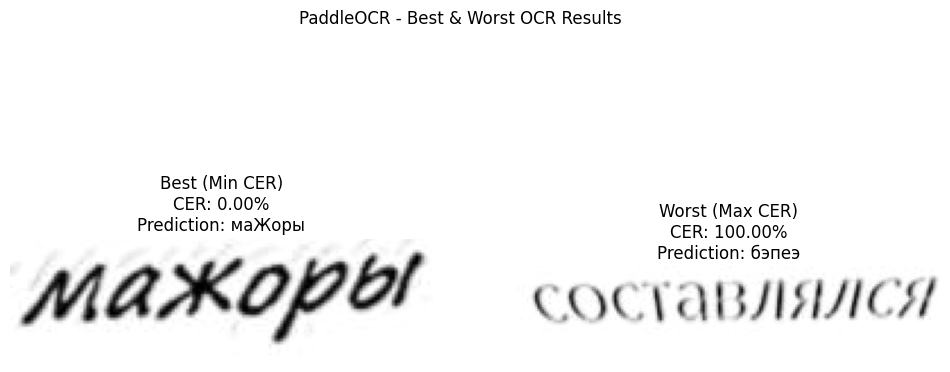

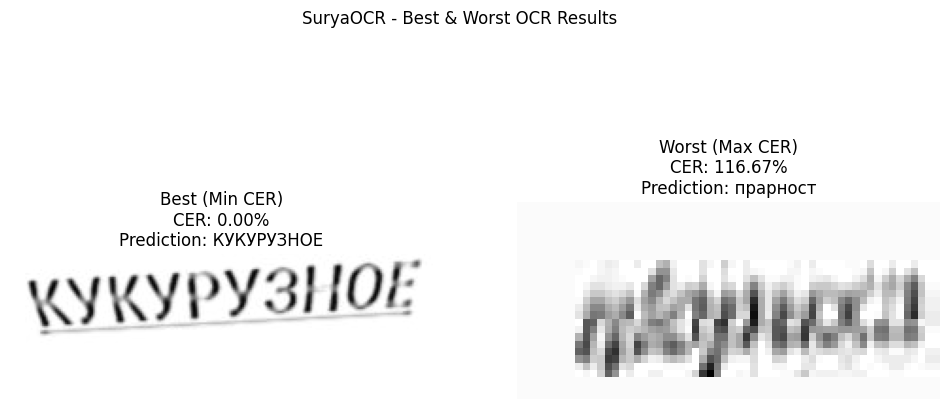

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image

# Function to Plot Best & Worst Examples
def plot_best_worst_examples(df_cer):
    models = df_cer["Model"].unique()

    for model_name in models:
        # Filter data for the current model
        model_data = df_cer[df_cer["Model"] == model_name]

        if model_data.empty:
            print(f"No data available for model: {model_name}")
            continue  # Skip if no data is available

        # Find best (min WER) and worst (max WER) examples
        best_example = model_data.loc[model_data["CER"].dropna().idxmin()]
        worst_example = model_data.loc[model_data["CER"].dropna().idxmax()]

        # Function to load and plot image
        def plot_example(example, title):
            img_path = example["Image"]
            if not os.path.exists(img_path):
                print(f"Image not found: {img_path}")
                return  # Skip missing image

            img = Image.open(img_path).convert("L")
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(f"{title}\nCER: {example['CER']:.2%}\nPrediction: {example['Prediction'][:100]}")

        # Display images with best and worst WER
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        plt.suptitle(f"{model_name} - Best & Worst OCR Results")

        # Best Example
        plt.subplot(1, 2, 1)
        plot_example(best_example, f"Best (Min CER)")

        # Worst Example
        plt.subplot(1, 2, 2)
        plot_example(worst_example, f"Worst (Max CER)")

        plt.show()  # Show both images together

# Show best & worst results for all models
plot_best_worst_examples(df_cer)

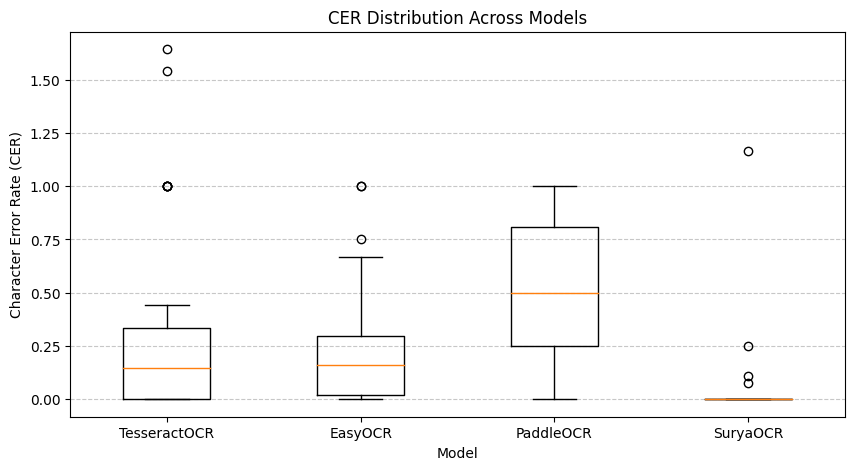

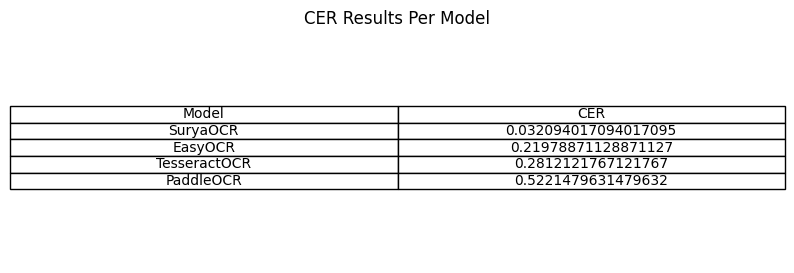

Results saved as CSV files:
- CER per sample: /kaggle/working/cer_per_sample_ocr.csv
- Average CER per model: /kaggle/working/average_cer_per_model_ocr.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot CER Distribution
plt.figure(figsize=(10, 5))
plt.boxplot([df_cer[df_cer["Model"] == model]["CER"] for model in df_cer["Model"].unique()], labels=df_cer["Model"].unique())
plt.title("CER Distribution Across Models")
plt.xlabel("Model")
plt.ylabel("Character Error Rate (CER)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Compute Average CER per Model
avg_cer_per_model = df_cer.groupby("Model")["CER"].mean().reset_index()
avg_cer_per_model = avg_cer_per_model.sort_values(by="CER")  # Sort for readability

# Show CER summary table
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=avg_cer_per_model.values, colLabels=avg_cer_per_model.columns, cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title("CER Results Per Model")
plt.show()

# Save results as CSV files
df_cer.to_csv("/kaggle/working/cer_per_sample_ocr.csv",mode="w", index=False)
avg_cer_per_model.to_csv("/kaggle/working/average_cer_per_model_ocr.csv",mode="w", index=False)

# Print confirmation
print("Results saved as CSV files:")
print("- CER per sample: /kaggle/working/cer_per_sample_ocr.csv")
print("- Average CER per model: /kaggle/working/average_cer_per_model_ocr.csv")